In [1]:
"""
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Reference:
    http://www.deeplearning.net/tutorial/lstm.html#lstm
    https://github.com/llSourcell/LSTM_Networks/blob/master/LSTM%20Demo.ipynb
    https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/recurrent_network.py
    Recurrent Neural Network.
    A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.
    This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
    Links:
    [Long Short Term Memory](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf)
    [MNIST Dataset](http://yann.lecun.com/exdb/mnist/).
    Author: Aymeric Damien
    Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from importlib import import_module

H = 5
N = 10

#Reference: Denis
def generate_parity_sequences(N, count):
    """
    Generate :count: sequences of length :N:.
    If odd # of 1's -> output 1
    else -> output 0
    """
    xor = lambda x: 1 if (x % 2 == 1) else 0
    sequences = np.random.choice([0, 1], size=[count, N], replace=True)
    counts = np.count_nonzero(sequences == 1, axis=1)
    # xor each sequence, expand dimensions by 1 to match sequences shape
    y = np.expand_dims(np.array([xor(x) for x in counts]), axis=1)

    # In case if you wanted to have the answer just appended at the end of the sequence:
    #     # append the answer at the end of each sequence
    #     seq_plus_y = np.concatenate([sequences, y], axis=1)
    #     print(sequences.shape, y.shape, seq_plus_y.shape)
    #     return seq_plus_y
    return np.expand_dims(sequences, axis=2), y

#Reference: Modified from Denis by Bo Cao
def generate_parity_sequences(N, count):
    """
    Generate :count: sequences of length :N:.
    If odd # of 1's -> output 1
    else -> output 0
    """
    xor = lambda x: 1 if (x % 2 == 1) else 0
    sequences = np.random.choice([0, 1], size=[count, N], replace=True)
    counts = np.count_nonzero(sequences == 1, axis=1)
    # xor each sequence, expand dimensions by 1 to match sequences shape
    y = np.expand_dims(np.array([xor(x) for x in counts]), axis=1)

    # In case if you wanted to have the answer just appended at the end of the sequence:
    #     # append the answer at the end of each sequence
    #     seq_plus_y = np.concatenate([sequences, y], axis=1)
    #     print(sequences.shape, y.shape, seq_plus_y.shape)
    #     return seq_plus_y
    
    new_y = []
    for i in range(len(y)):
        new_yy = []
        if y[i] == 0:
            new_yy.append(0)
            new_yy.append(1)
        else:
            new_yy.append(1)
            new_yy.append(0)
        new_y.append(new_yy)

    return np.expand_dims(sequences, axis=2), new_y

In [2]:
# Training Parameters
learning_rate = 0.018
batch_size = 128
display_step = batch_size * 100

#batch_steps = 10000 / batch_size
epochs = 10000

# Network Parameters
num_input = 1 # 
timesteps = N # timesteps
num_hidden = H # hidden layer num of features
num_classes = 2 # 0 or 1

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}


def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a RNN cell with tensorflow
    rnn_cell = rnn.BasicRNNCell(num_hidden)

    # Get RNN cell output
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

logits = RNN(X, weights, biases)
#prediction = tf.nn.softmax(logits)
prediction = tf.tanh(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

test_accuracies_10replications = []
losses_1st_replication = [] #epoch as unit
test_accuracies_1st_replication = [] #epoch as unit
train_accuracies_1st_replication = [] #epoch as unit

# Start training
with tf.Session() as sess:
    
    # Run 10 replications
    for replication in range(10):
        
        print("Replication: %d: " % replication)
        
        # Initialize random weights
        train_data = generate_parity_sequences(N, 10000)
        train_data_x = train_data[0]
        train_data_y = train_data[1]
        test_data = generate_parity_sequences(N, 10000)
        test_data_x = test_data[0]
        test_data_y = test_data[1]
        
        # Run the initializer
        sess.run(init)
    
        for epoch in range(epochs):
            batch_index = 0
            while batch_index < 10000:

                train_data_batch_x = []
                train_data_batch_y = []
                if batch_index + batch_size < 10000: 
                    train_data_batch_x = train_data_x[batch_index : batch_index + batch_size]
                    train_data_batch_y = train_data_y[batch_index : batch_index + batch_size]
                else:
                    train_data_batch_x = train_data_x[batch_index : ]
                    train_data_batch_y = train_data_y[batch_index : ]

                #batch_x, batch_y = mnist.train.next_batch(batch_size)
                # Reshape data to get 28 seq of 28 elements
                #batch_x = batch_x.reshape((batch_size, timesteps, num_input))
                #train_data_x = train_data_x.reshape((10000, timesteps, num_input))
                #print("train_data_batch_x.shape:  " , train_data_batch_x.shape)
                if batch_index + batch_size < 10000: 
                    train_data_batch_x = train_data_batch_x.reshape((batch_size, timesteps, num_input))
                else:
                    train_data_batch_x = train_data_batch_x.reshape((10000 % batch_size, timesteps, num_input))
                # Run optimization op (backprop)
                #sess.run(train_op, feed_dict={X: train_data_x, 
                 #                             Y: train_data_y})
                sess.run(train_op, feed_dict={X: train_data_batch_x, 
                                              Y: train_data_batch_y})

                batch_index += batch_size

            if replication == 0:
                loss, train_accuracy = sess.run([loss_op, accuracy], feed_dict={X: train_data_x, Y: train_data_y})
                test_accuracy = sess.run(accuracy, feed_dict={X: test_data_x, Y: test_data_y})
                losses_1st_replication.append(loss)
                train_accuracies_1st_replication.append(train_accuracy)
                test_accuracies_1st_replication.append(test_accuracy)
            
            if epoch % 10 == 0:
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: train_data_x,
                                                                         Y: train_data_y})
                print("Epoch: " + str(epoch) + \
                          ", Loss= " + \
                          "{:.4f}".format(loss) + ", Training Accuracy= " + \
                          "{:.3f}".format(acc))

        print("Optimization Finished!")

        test_data_x = test_data_x.reshape((-1, timesteps, num_input))
        test_data_y = test_data_y
        test_accuracy = sess.run(accuracy, feed_dict={X: test_data_x, Y: test_data_y})
        test_accuracies_10replications.append(test_accuracy)
        print("Testing Accuracy:", test_accuracy)

Replication: 0: 
Epoch: 0, Loss= 0.7042, Training Accuracy= 0.504
Epoch: 10, Loss= 0.6935, Training Accuracy= 0.514
Epoch: 20, Loss= 0.6934, Training Accuracy= 0.515
Epoch: 30, Loss= 0.6933, Training Accuracy= 0.513
Epoch: 40, Loss= 0.6932, Training Accuracy= 0.511
Epoch: 50, Loss= 0.6932, Training Accuracy= 0.512
Epoch: 60, Loss= 0.6931, Training Accuracy= 0.512
Epoch: 70, Loss= 0.6931, Training Accuracy= 0.512
Epoch: 80, Loss= 0.6931, Training Accuracy= 0.512
Epoch: 90, Loss= 0.6931, Training Accuracy= 0.512
Epoch: 100, Loss= 0.6931, Training Accuracy= 0.511
Epoch: 110, Loss= 0.6930, Training Accuracy= 0.513
Epoch: 120, Loss= 0.6930, Training Accuracy= 0.511
Epoch: 130, Loss= 0.6930, Training Accuracy= 0.512
Epoch: 140, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 150, Loss= 0.6930, Training Accuracy= 0.511
Epoch: 160, Loss= 0.6930, Training Accuracy= 0.511
Epoch: 170, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 180, Loss= 0.6930, Training Accuracy= 0.507
Epoch: 190, Loss= 0.6930,

Epoch: 1600, Loss= 0.6922, Training Accuracy= 0.512
Epoch: 1610, Loss= 0.6922, Training Accuracy= 0.513
Epoch: 1620, Loss= 0.6922, Training Accuracy= 0.513
Epoch: 1630, Loss= 0.6922, Training Accuracy= 0.510
Epoch: 1640, Loss= 0.6922, Training Accuracy= 0.515
Epoch: 1650, Loss= 0.6922, Training Accuracy= 0.518
Epoch: 1660, Loss= 0.6922, Training Accuracy= 0.520
Epoch: 1670, Loss= 0.6922, Training Accuracy= 0.518
Epoch: 1680, Loss= 0.6922, Training Accuracy= 0.516
Epoch: 1690, Loss= 0.6922, Training Accuracy= 0.516
Epoch: 1700, Loss= 0.6922, Training Accuracy= 0.515
Epoch: 1710, Loss= 0.6921, Training Accuracy= 0.516
Epoch: 1720, Loss= 0.6921, Training Accuracy= 0.516
Epoch: 1730, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 1740, Loss= 0.6921, Training Accuracy= 0.511
Epoch: 1750, Loss= 0.6921, Training Accuracy= 0.505
Epoch: 1760, Loss= 0.6920, Training Accuracy= 0.500
Epoch: 1770, Loss= 0.6920, Training Accuracy= 0.499
Epoch: 1780, Loss= 0.6920, Training Accuracy= 0.496
Epoch: 1790,

Epoch: 3180, Loss= 0.0010, Training Accuracy= 1.000
Epoch: 3190, Loss= 0.0010, Training Accuracy= 1.000
Epoch: 3200, Loss= 0.0010, Training Accuracy= 1.000
Epoch: 3210, Loss= 0.0010, Training Accuracy= 1.000
Epoch: 3220, Loss= 0.0010, Training Accuracy= 1.000
Epoch: 3230, Loss= 0.0009, Training Accuracy= 1.000
Epoch: 3240, Loss= 0.0009, Training Accuracy= 1.000
Epoch: 3250, Loss= 0.0009, Training Accuracy= 1.000
Epoch: 3260, Loss= 0.0009, Training Accuracy= 1.000
Epoch: 3270, Loss= 0.0009, Training Accuracy= 1.000
Epoch: 3280, Loss= 0.0009, Training Accuracy= 1.000
Epoch: 3290, Loss= 0.0009, Training Accuracy= 1.000
Epoch: 3300, Loss= 0.0009, Training Accuracy= 1.000
Epoch: 3310, Loss= 0.0009, Training Accuracy= 1.000
Epoch: 3320, Loss= 0.0008, Training Accuracy= 1.000
Epoch: 3330, Loss= 0.0008, Training Accuracy= 1.000
Epoch: 3340, Loss= 0.0008, Training Accuracy= 1.000
Epoch: 3350, Loss= 0.0008, Training Accuracy= 1.000
Epoch: 3360, Loss= 0.0008, Training Accuracy= 1.000
Epoch: 3370,

Epoch: 4760, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4770, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4780, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4790, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4800, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4810, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4820, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4830, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4840, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4850, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4860, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4870, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4880, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4890, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4900, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4910, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4920, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4930, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4940, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 4950,

Epoch: 6340, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6350, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6360, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6370, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6380, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6390, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6400, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6410, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6420, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6430, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6440, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6450, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6460, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6470, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6480, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6490, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6500, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6510, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6520, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6530,

Epoch: 7920, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 7930, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 7940, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 7950, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 7960, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 7970, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 7980, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 7990, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 8000, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 8010, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 8020, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 8030, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 8040, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 8050, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 8060, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 8070, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 8080, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 8090, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 8100, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 8110,

Epoch: 9500, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9510, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9520, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9530, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9540, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9550, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9560, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9570, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9580, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9590, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9600, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9610, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9620, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9630, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9640, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9650, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9660, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9670, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9680, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9690,

Epoch: 1090, Loss= 0.6922, Training Accuracy= 0.516
Epoch: 1100, Loss= 0.6922, Training Accuracy= 0.516
Epoch: 1110, Loss= 0.6922, Training Accuracy= 0.515
Epoch: 1120, Loss= 0.6921, Training Accuracy= 0.516
Epoch: 1130, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 1140, Loss= 0.6921, Training Accuracy= 0.512
Epoch: 1150, Loss= 0.6921, Training Accuracy= 0.511
Epoch: 1160, Loss= 0.6921, Training Accuracy= 0.512
Epoch: 1170, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 1180, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 1190, Loss= 0.6921, Training Accuracy= 0.517
Epoch: 1200, Loss= 0.6921, Training Accuracy= 0.520
Epoch: 1210, Loss= 0.6920, Training Accuracy= 0.523
Epoch: 1220, Loss= 0.6920, Training Accuracy= 0.521
Epoch: 1230, Loss= 0.6920, Training Accuracy= 0.519
Epoch: 1240, Loss= 0.6920, Training Accuracy= 0.521
Epoch: 1250, Loss= 0.6920, Training Accuracy= 0.522
Epoch: 1260, Loss= 0.6920, Training Accuracy= 0.526
Epoch: 1270, Loss= 0.6920, Training Accuracy= 0.522
Epoch: 1280,

Epoch: 2670, Loss= 0.6945, Training Accuracy= 0.509
Epoch: 2680, Loss= 0.6945, Training Accuracy= 0.509
Epoch: 2690, Loss= 0.6945, Training Accuracy= 0.509
Epoch: 2700, Loss= 0.6944, Training Accuracy= 0.510
Epoch: 2710, Loss= 0.6944, Training Accuracy= 0.511
Epoch: 2720, Loss= 0.6944, Training Accuracy= 0.511
Epoch: 2730, Loss= 0.6944, Training Accuracy= 0.511
Epoch: 2740, Loss= 0.6944, Training Accuracy= 0.511
Epoch: 2750, Loss= 0.6944, Training Accuracy= 0.512
Epoch: 2760, Loss= 0.6944, Training Accuracy= 0.512
Epoch: 2770, Loss= 0.6944, Training Accuracy= 0.511
Epoch: 2780, Loss= 0.6944, Training Accuracy= 0.511
Epoch: 2790, Loss= 0.6944, Training Accuracy= 0.511
Epoch: 2800, Loss= 0.6944, Training Accuracy= 0.511
Epoch: 2810, Loss= 0.6944, Training Accuracy= 0.511
Epoch: 2820, Loss= 0.6944, Training Accuracy= 0.512
Epoch: 2830, Loss= 0.6944, Training Accuracy= 0.512
Epoch: 2840, Loss= 0.6944, Training Accuracy= 0.512
Epoch: 2850, Loss= 0.6944, Training Accuracy= 0.512
Epoch: 2860,

Epoch: 4250, Loss= 0.6937, Training Accuracy= 0.510
Epoch: 4260, Loss= 0.6937, Training Accuracy= 0.510
Epoch: 4270, Loss= 0.6937, Training Accuracy= 0.510
Epoch: 4280, Loss= 0.6937, Training Accuracy= 0.510
Epoch: 4290, Loss= 0.6937, Training Accuracy= 0.510
Epoch: 4300, Loss= 0.6937, Training Accuracy= 0.512
Epoch: 4310, Loss= 0.6937, Training Accuracy= 0.512
Epoch: 4320, Loss= 0.6937, Training Accuracy= 0.513
Epoch: 4330, Loss= 0.6937, Training Accuracy= 0.513
Epoch: 4340, Loss= 0.6937, Training Accuracy= 0.512
Epoch: 4350, Loss= 0.6937, Training Accuracy= 0.512
Epoch: 4360, Loss= 0.6937, Training Accuracy= 0.512
Epoch: 4370, Loss= 0.6937, Training Accuracy= 0.512
Epoch: 4380, Loss= 0.6937, Training Accuracy= 0.513
Epoch: 4390, Loss= 0.6937, Training Accuracy= 0.515
Epoch: 4400, Loss= 0.6937, Training Accuracy= 0.515
Epoch: 4410, Loss= 0.6937, Training Accuracy= 0.515
Epoch: 4420, Loss= 0.6937, Training Accuracy= 0.515
Epoch: 4430, Loss= 0.6937, Training Accuracy= 0.515
Epoch: 4440,

Epoch: 5830, Loss= 0.6931, Training Accuracy= 0.515
Epoch: 5840, Loss= 0.6931, Training Accuracy= 0.515
Epoch: 5850, Loss= 0.6931, Training Accuracy= 0.515
Epoch: 5860, Loss= 0.6931, Training Accuracy= 0.515
Epoch: 5870, Loss= 0.6931, Training Accuracy= 0.515
Epoch: 5880, Loss= 0.6931, Training Accuracy= 0.513
Epoch: 5890, Loss= 0.6931, Training Accuracy= 0.515
Epoch: 5900, Loss= 0.6931, Training Accuracy= 0.515
Epoch: 5910, Loss= 0.6931, Training Accuracy= 0.515
Epoch: 5920, Loss= 0.6931, Training Accuracy= 0.515
Epoch: 5930, Loss= 0.6930, Training Accuracy= 0.515
Epoch: 5940, Loss= 0.6930, Training Accuracy= 0.515
Epoch: 5950, Loss= 0.6930, Training Accuracy= 0.515
Epoch: 5960, Loss= 0.6930, Training Accuracy= 0.514
Epoch: 5970, Loss= 0.6930, Training Accuracy= 0.512
Epoch: 5980, Loss= 0.6930, Training Accuracy= 0.512
Epoch: 5990, Loss= 0.6930, Training Accuracy= 0.513
Epoch: 6000, Loss= 0.6930, Training Accuracy= 0.513
Epoch: 6010, Loss= 0.6930, Training Accuracy= 0.513
Epoch: 6020,

Epoch: 7410, Loss= 0.6922, Training Accuracy= 0.511
Epoch: 7420, Loss= 0.6932, Training Accuracy= 0.512
Epoch: 7430, Loss= 0.6941, Training Accuracy= 0.511
Epoch: 7440, Loss= 0.6909, Training Accuracy= 0.512
Epoch: 7450, Loss= 0.6923, Training Accuracy= 0.516
Epoch: 7460, Loss= 0.6930, Training Accuracy= 0.511
Epoch: 7470, Loss= 0.6929, Training Accuracy= 0.511
Epoch: 7480, Loss= 0.6917, Training Accuracy= 0.514
Epoch: 7490, Loss= 0.6910, Training Accuracy= 0.516
Epoch: 7500, Loss= 0.6901, Training Accuracy= 0.513
Epoch: 7510, Loss= 0.6892, Training Accuracy= 0.509
Epoch: 7520, Loss= 0.6894, Training Accuracy= 0.508
Epoch: 7530, Loss= 0.6915, Training Accuracy= 0.509
Epoch: 7540, Loss= 0.6892, Training Accuracy= 0.510
Epoch: 7550, Loss= 0.6914, Training Accuracy= 0.509
Epoch: 7560, Loss= 0.6912, Training Accuracy= 0.514
Epoch: 7570, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 7580, Loss= 0.6898, Training Accuracy= 0.512
Epoch: 7590, Loss= 0.6897, Training Accuracy= 0.516
Epoch: 7600,

Epoch: 8990, Loss= 0.6944, Training Accuracy= 0.510
Epoch: 9000, Loss= 0.6941, Training Accuracy= 0.510
Epoch: 9010, Loss= 0.6938, Training Accuracy= 0.510
Epoch: 9020, Loss= 0.6936, Training Accuracy= 0.510
Epoch: 9030, Loss= 0.6934, Training Accuracy= 0.510
Epoch: 9040, Loss= 0.6932, Training Accuracy= 0.510
Epoch: 9050, Loss= 0.6930, Training Accuracy= 0.512
Epoch: 9060, Loss= 0.6928, Training Accuracy= 0.509
Epoch: 9070, Loss= 0.6927, Training Accuracy= 0.511
Epoch: 9080, Loss= 0.6927, Training Accuracy= 0.509
Epoch: 9090, Loss= 0.6938, Training Accuracy= 0.510
Epoch: 9100, Loss= 0.6900, Training Accuracy= 0.515
Epoch: 9110, Loss= 0.6900, Training Accuracy= 0.513
Epoch: 9120, Loss= 0.6887, Training Accuracy= 0.511
Epoch: 9130, Loss= 0.6919, Training Accuracy= 0.514
Epoch: 9140, Loss= 0.6894, Training Accuracy= 0.509
Epoch: 9150, Loss= 0.6908, Training Accuracy= 0.518
Epoch: 9160, Loss= 0.6933, Training Accuracy= 0.508
Epoch: 9170, Loss= 0.6889, Training Accuracy= 0.511
Epoch: 9180,

Epoch: 570, Loss= 0.6925, Training Accuracy= 0.518
Epoch: 580, Loss= 0.6925, Training Accuracy= 0.519
Epoch: 590, Loss= 0.6925, Training Accuracy= 0.520
Epoch: 600, Loss= 0.6925, Training Accuracy= 0.520
Epoch: 610, Loss= 0.6925, Training Accuracy= 0.520
Epoch: 620, Loss= 0.6925, Training Accuracy= 0.520
Epoch: 630, Loss= 0.6925, Training Accuracy= 0.520
Epoch: 640, Loss= 0.6925, Training Accuracy= 0.518
Epoch: 650, Loss= 0.6925, Training Accuracy= 0.517
Epoch: 660, Loss= 0.6925, Training Accuracy= 0.515
Epoch: 670, Loss= 0.6925, Training Accuracy= 0.515
Epoch: 680, Loss= 0.6925, Training Accuracy= 0.515
Epoch: 690, Loss= 0.6925, Training Accuracy= 0.516
Epoch: 700, Loss= 0.6925, Training Accuracy= 0.515
Epoch: 710, Loss= 0.6925, Training Accuracy= 0.514
Epoch: 720, Loss= 0.6925, Training Accuracy= 0.515
Epoch: 730, Loss= 0.6925, Training Accuracy= 0.516
Epoch: 740, Loss= 0.6925, Training Accuracy= 0.514
Epoch: 750, Loss= 0.6925, Training Accuracy= 0.513
Epoch: 760, Loss= 0.6925, Train

Epoch: 2160, Loss= 0.6921, Training Accuracy= 0.511
Epoch: 2170, Loss= 0.6921, Training Accuracy= 0.511
Epoch: 2180, Loss= 0.6921, Training Accuracy= 0.512
Epoch: 2190, Loss= 0.6921, Training Accuracy= 0.513
Epoch: 2200, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 2210, Loss= 0.6921, Training Accuracy= 0.513
Epoch: 2220, Loss= 0.6921, Training Accuracy= 0.516
Epoch: 2230, Loss= 0.6921, Training Accuracy= 0.516
Epoch: 2240, Loss= 0.6921, Training Accuracy= 0.516
Epoch: 2250, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 2260, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 2270, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 2280, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 2290, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 2300, Loss= 0.6921, Training Accuracy= 0.513
Epoch: 2310, Loss= 0.6921, Training Accuracy= 0.513
Epoch: 2320, Loss= 0.6921, Training Accuracy= 0.513
Epoch: 2330, Loss= 0.6921, Training Accuracy= 0.512
Epoch: 2340, Loss= 0.6921, Training Accuracy= 0.511
Epoch: 2350,

Epoch: 3740, Loss= 0.6918, Training Accuracy= 0.518
Epoch: 3750, Loss= 0.6918, Training Accuracy= 0.518
Epoch: 3760, Loss= 0.6918, Training Accuracy= 0.519
Epoch: 3770, Loss= 0.6918, Training Accuracy= 0.518
Epoch: 3780, Loss= 0.6918, Training Accuracy= 0.518
Epoch: 3790, Loss= 0.6918, Training Accuracy= 0.518
Epoch: 3800, Loss= 0.6917, Training Accuracy= 0.518
Epoch: 3810, Loss= 0.6917, Training Accuracy= 0.518
Epoch: 3820, Loss= 0.6917, Training Accuracy= 0.518
Epoch: 3830, Loss= 0.6917, Training Accuracy= 0.518
Epoch: 3840, Loss= 0.6917, Training Accuracy= 0.517
Epoch: 3850, Loss= 0.6917, Training Accuracy= 0.518
Epoch: 3860, Loss= 0.6917, Training Accuracy= 0.519
Epoch: 3870, Loss= 0.6917, Training Accuracy= 0.520
Epoch: 3880, Loss= 0.6917, Training Accuracy= 0.520
Epoch: 3890, Loss= 0.6917, Training Accuracy= 0.520
Epoch: 3900, Loss= 0.6917, Training Accuracy= 0.520
Epoch: 3910, Loss= 0.6917, Training Accuracy= 0.521
Epoch: 3920, Loss= 0.6917, Training Accuracy= 0.521
Epoch: 3930,

Epoch: 5320, Loss= 0.6767, Training Accuracy= 0.574
Epoch: 5330, Loss= 0.6755, Training Accuracy= 0.577
Epoch: 5340, Loss= 0.6746, Training Accuracy= 0.577
Epoch: 5350, Loss= 0.6683, Training Accuracy= 0.570
Epoch: 5360, Loss= 0.6680, Training Accuracy= 0.587
Epoch: 5370, Loss= 0.6660, Training Accuracy= 0.590
Epoch: 5380, Loss= 0.6624, Training Accuracy= 0.591
Epoch: 5390, Loss= 0.6610, Training Accuracy= 0.609
Epoch: 5400, Loss= 0.6642, Training Accuracy= 0.607
Epoch: 5410, Loss= 0.6631, Training Accuracy= 0.609
Epoch: 5420, Loss= 0.6639, Training Accuracy= 0.610
Epoch: 5430, Loss= 0.6531, Training Accuracy= 0.641
Epoch: 5440, Loss= 0.6513, Training Accuracy= 0.650
Epoch: 5450, Loss= 0.6646, Training Accuracy= 0.629
Epoch: 5460, Loss= 0.6611, Training Accuracy= 0.638
Epoch: 5470, Loss= 0.6544, Training Accuracy= 0.628
Epoch: 5480, Loss= 0.6467, Training Accuracy= 0.648
Epoch: 5490, Loss= 0.6798, Training Accuracy= 0.599
Epoch: 5500, Loss= 0.6451, Training Accuracy= 0.664
Epoch: 5510,

Epoch: 6900, Loss= 0.6911, Training Accuracy= 0.516
Epoch: 6910, Loss= 0.6911, Training Accuracy= 0.516
Epoch: 6920, Loss= 0.6911, Training Accuracy= 0.516
Epoch: 6930, Loss= 0.6911, Training Accuracy= 0.516
Epoch: 6940, Loss= 0.6911, Training Accuracy= 0.516
Epoch: 6950, Loss= 0.6911, Training Accuracy= 0.516
Epoch: 6960, Loss= 0.6911, Training Accuracy= 0.516
Epoch: 6970, Loss= 0.6911, Training Accuracy= 0.516
Epoch: 6980, Loss= 0.6911, Training Accuracy= 0.516
Epoch: 6990, Loss= 0.6911, Training Accuracy= 0.516
Epoch: 7000, Loss= 0.6911, Training Accuracy= 0.516
Epoch: 7010, Loss= 0.6910, Training Accuracy= 0.516
Epoch: 7020, Loss= 0.6910, Training Accuracy= 0.516
Epoch: 7030, Loss= 0.6910, Training Accuracy= 0.516
Epoch: 7040, Loss= 0.6910, Training Accuracy= 0.516
Epoch: 7050, Loss= 0.6910, Training Accuracy= 0.516
Epoch: 7060, Loss= 0.6910, Training Accuracy= 0.516
Epoch: 7070, Loss= 0.6910, Training Accuracy= 0.516
Epoch: 7080, Loss= 0.6910, Training Accuracy= 0.516
Epoch: 7090,

Epoch: 8480, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8490, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8500, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8510, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8520, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8530, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8540, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8550, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8560, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8570, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8580, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8590, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8600, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8610, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8620, Loss= 0.6906, Training Accuracy= 0.515
Epoch: 8630, Loss= 0.6906, Training Accuracy= 0.514
Epoch: 8640, Loss= 0.6906, Training Accuracy= 0.514
Epoch: 8650, Loss= 0.6906, Training Accuracy= 0.514
Epoch: 8660, Loss= 0.6906, Training Accuracy= 0.514
Epoch: 8670,

Epoch: 50, Loss= 0.6924, Training Accuracy= 0.510
Epoch: 60, Loss= 0.6924, Training Accuracy= 0.509
Epoch: 70, Loss= 0.6924, Training Accuracy= 0.509
Epoch: 80, Loss= 0.6924, Training Accuracy= 0.510
Epoch: 90, Loss= 0.6924, Training Accuracy= 0.512
Epoch: 100, Loss= 0.6924, Training Accuracy= 0.509
Epoch: 110, Loss= 0.6924, Training Accuracy= 0.511
Epoch: 120, Loss= 0.6924, Training Accuracy= 0.509
Epoch: 130, Loss= 0.6924, Training Accuracy= 0.512
Epoch: 140, Loss= 0.6924, Training Accuracy= 0.511
Epoch: 150, Loss= 0.6924, Training Accuracy= 0.512
Epoch: 160, Loss= 0.6924, Training Accuracy= 0.511
Epoch: 170, Loss= 0.6923, Training Accuracy= 0.511
Epoch: 180, Loss= 0.6923, Training Accuracy= 0.511
Epoch: 190, Loss= 0.6923, Training Accuracy= 0.511
Epoch: 200, Loss= 0.6923, Training Accuracy= 0.512
Epoch: 210, Loss= 0.6923, Training Accuracy= 0.513
Epoch: 220, Loss= 0.6923, Training Accuracy= 0.513
Epoch: 230, Loss= 0.6923, Training Accuracy= 0.514
Epoch: 240, Loss= 0.6923, Training A

Epoch: 1650, Loss= 0.6918, Training Accuracy= 0.514
Epoch: 1660, Loss= 0.6918, Training Accuracy= 0.514
Epoch: 1670, Loss= 0.6918, Training Accuracy= 0.514
Epoch: 1680, Loss= 0.6918, Training Accuracy= 0.515
Epoch: 1690, Loss= 0.6918, Training Accuracy= 0.515
Epoch: 1700, Loss= 0.6918, Training Accuracy= 0.515
Epoch: 1710, Loss= 0.6918, Training Accuracy= 0.514
Epoch: 1720, Loss= 0.6918, Training Accuracy= 0.516
Epoch: 1730, Loss= 0.6918, Training Accuracy= 0.516
Epoch: 1740, Loss= 0.6918, Training Accuracy= 0.516
Epoch: 1750, Loss= 0.6918, Training Accuracy= 0.514
Epoch: 1760, Loss= 0.6918, Training Accuracy= 0.512
Epoch: 1770, Loss= 0.6918, Training Accuracy= 0.512
Epoch: 1780, Loss= 0.6918, Training Accuracy= 0.512
Epoch: 1790, Loss= 0.6918, Training Accuracy= 0.512
Epoch: 1800, Loss= 0.6918, Training Accuracy= 0.512
Epoch: 1810, Loss= 0.6918, Training Accuracy= 0.511
Epoch: 1820, Loss= 0.6918, Training Accuracy= 0.510
Epoch: 1830, Loss= 0.6918, Training Accuracy= 0.510
Epoch: 1840,

Epoch: 3230, Loss= 0.6754, Training Accuracy= 0.528
Epoch: 3240, Loss= 0.6753, Training Accuracy= 0.529
Epoch: 3250, Loss= 0.6752, Training Accuracy= 0.530
Epoch: 3260, Loss= 0.6755, Training Accuracy= 0.530
Epoch: 3270, Loss= 0.6757, Training Accuracy= 0.533
Epoch: 3280, Loss= 0.6760, Training Accuracy= 0.535
Epoch: 3290, Loss= 0.6760, Training Accuracy= 0.535
Epoch: 3300, Loss= 0.6763, Training Accuracy= 0.534
Epoch: 3310, Loss= 0.6764, Training Accuracy= 0.536
Epoch: 3320, Loss= 0.6759, Training Accuracy= 0.535
Epoch: 3330, Loss= 0.6769, Training Accuracy= 0.538
Epoch: 3340, Loss= 0.6780, Training Accuracy= 0.540
Epoch: 3350, Loss= 0.6780, Training Accuracy= 0.540
Epoch: 3360, Loss= 0.6781, Training Accuracy= 0.539
Epoch: 3370, Loss= 0.6781, Training Accuracy= 0.539
Epoch: 3380, Loss= 0.6704, Training Accuracy= 0.543
Epoch: 3390, Loss= 0.6700, Training Accuracy= 0.545
Epoch: 3400, Loss= 0.6694, Training Accuracy= 0.545
Epoch: 3410, Loss= 0.6693, Training Accuracy= 0.548
Epoch: 3420,

Epoch: 4810, Loss= 0.6729, Training Accuracy= 0.532
Epoch: 4820, Loss= 0.6729, Training Accuracy= 0.531
Epoch: 4830, Loss= 0.6729, Training Accuracy= 0.531
Epoch: 4840, Loss= 0.6729, Training Accuracy= 0.531
Epoch: 4850, Loss= 0.6730, Training Accuracy= 0.531
Epoch: 4860, Loss= 0.6731, Training Accuracy= 0.531
Epoch: 4870, Loss= 0.6732, Training Accuracy= 0.530
Epoch: 4880, Loss= 0.6733, Training Accuracy= 0.529
Epoch: 4890, Loss= 0.6734, Training Accuracy= 0.529
Epoch: 4900, Loss= 0.6736, Training Accuracy= 0.531
Epoch: 4910, Loss= 0.6738, Training Accuracy= 0.530
Epoch: 4920, Loss= 0.6741, Training Accuracy= 0.531
Epoch: 4930, Loss= 0.6746, Training Accuracy= 0.531
Epoch: 4940, Loss= 0.6752, Training Accuracy= 0.531
Epoch: 4950, Loss= 0.6760, Training Accuracy= 0.531
Epoch: 4960, Loss= 0.6768, Training Accuracy= 0.529
Epoch: 4970, Loss= 0.6775, Training Accuracy= 0.529
Epoch: 4980, Loss= 0.6781, Training Accuracy= 0.528
Epoch: 4990, Loss= 0.6790, Training Accuracy= 0.528
Epoch: 5000,

Epoch: 6390, Loss= 0.6927, Training Accuracy= 0.509
Epoch: 6400, Loss= 0.6927, Training Accuracy= 0.509
Epoch: 6410, Loss= 0.6926, Training Accuracy= 0.509
Epoch: 6420, Loss= 0.6925, Training Accuracy= 0.510
Epoch: 6430, Loss= 0.6905, Training Accuracy= 0.524
Epoch: 6440, Loss= 0.6890, Training Accuracy= 0.523
Epoch: 6450, Loss= 0.6922, Training Accuracy= 0.509
Epoch: 6460, Loss= 0.6927, Training Accuracy= 0.512
Epoch: 6470, Loss= 0.7992, Training Accuracy= 0.507
Epoch: 6480, Loss= 0.6873, Training Accuracy= 0.521
Epoch: 6490, Loss= 0.6974, Training Accuracy= 0.493
Epoch: 6500, Loss= 0.6933, Training Accuracy= 0.500
Epoch: 6510, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 6520, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 6530, Loss= 0.6930, Training Accuracy= 0.504
Epoch: 6540, Loss= 0.6930, Training Accuracy= 0.504
Epoch: 6550, Loss= 0.6930, Training Accuracy= 0.502
Epoch: 6560, Loss= 0.6929, Training Accuracy= 0.502
Epoch: 6570, Loss= 0.6929, Training Accuracy= 0.509
Epoch: 6580,

Epoch: 7970, Loss= 0.6909, Training Accuracy= 0.510
Epoch: 7980, Loss= 0.6909, Training Accuracy= 0.510
Epoch: 7990, Loss= 0.6909, Training Accuracy= 0.510
Epoch: 8000, Loss= 0.6909, Training Accuracy= 0.510
Epoch: 8010, Loss= 0.6909, Training Accuracy= 0.510
Epoch: 8020, Loss= 0.6909, Training Accuracy= 0.510
Epoch: 8030, Loss= 0.6909, Training Accuracy= 0.510
Epoch: 8040, Loss= 0.6909, Training Accuracy= 0.510
Epoch: 8050, Loss= 0.6909, Training Accuracy= 0.510
Epoch: 8060, Loss= 0.6908, Training Accuracy= 0.510
Epoch: 8070, Loss= 0.6908, Training Accuracy= 0.510
Epoch: 8080, Loss= 0.6908, Training Accuracy= 0.510
Epoch: 8090, Loss= 0.6908, Training Accuracy= 0.510
Epoch: 8100, Loss= 0.6908, Training Accuracy= 0.510
Epoch: 8110, Loss= 0.6908, Training Accuracy= 0.510
Epoch: 8120, Loss= 0.6908, Training Accuracy= 0.510
Epoch: 8130, Loss= 0.6908, Training Accuracy= 0.510
Epoch: 8140, Loss= 0.6908, Training Accuracy= 0.510
Epoch: 8150, Loss= 0.6908, Training Accuracy= 0.510
Epoch: 8160,

Epoch: 9550, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9560, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9570, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9580, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9590, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9600, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9610, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9620, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9630, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9640, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9650, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9660, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9670, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9680, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9690, Loss= 0.6906, Training Accuracy= 0.510
Epoch: 9700, Loss= 0.6905, Training Accuracy= 0.510
Epoch: 9710, Loss= 0.6905, Training Accuracy= 0.510
Epoch: 9720, Loss= 0.6905, Training Accuracy= 0.510
Epoch: 9730, Loss= 0.6905, Training Accuracy= 0.510
Epoch: 9740,

Epoch: 1140, Loss= 0.6929, Training Accuracy= 0.517
Epoch: 1150, Loss= 0.6928, Training Accuracy= 0.517
Epoch: 1160, Loss= 0.6928, Training Accuracy= 0.517
Epoch: 1170, Loss= 0.6928, Training Accuracy= 0.517
Epoch: 1180, Loss= 0.6928, Training Accuracy= 0.517
Epoch: 1190, Loss= 0.6928, Training Accuracy= 0.518
Epoch: 1200, Loss= 0.6928, Training Accuracy= 0.519
Epoch: 1210, Loss= 0.6928, Training Accuracy= 0.518
Epoch: 1220, Loss= 0.6928, Training Accuracy= 0.518
Epoch: 1230, Loss= 0.6928, Training Accuracy= 0.518
Epoch: 1240, Loss= 0.6928, Training Accuracy= 0.519
Epoch: 1250, Loss= 0.6928, Training Accuracy= 0.519
Epoch: 1260, Loss= 0.6928, Training Accuracy= 0.517
Epoch: 1270, Loss= 0.6928, Training Accuracy= 0.517
Epoch: 1280, Loss= 0.6928, Training Accuracy= 0.517
Epoch: 1290, Loss= 0.6928, Training Accuracy= 0.517
Epoch: 1300, Loss= 0.6928, Training Accuracy= 0.516
Epoch: 1310, Loss= 0.6928, Training Accuracy= 0.515
Epoch: 1320, Loss= 0.6928, Training Accuracy= 0.516
Epoch: 1330,

Epoch: 2720, Loss= 0.6927, Training Accuracy= 0.519
Epoch: 2730, Loss= 0.6927, Training Accuracy= 0.519
Epoch: 2740, Loss= 0.6927, Training Accuracy= 0.519
Epoch: 2750, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 2760, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 2770, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 2780, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 2790, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 2800, Loss= 0.6927, Training Accuracy= 0.519
Epoch: 2810, Loss= 0.6927, Training Accuracy= 0.519
Epoch: 2820, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 2830, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 2840, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 2850, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 2860, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 2870, Loss= 0.6927, Training Accuracy= 0.517
Epoch: 2880, Loss= 0.6927, Training Accuracy= 0.517
Epoch: 2890, Loss= 0.6927, Training Accuracy= 0.517
Epoch: 2900, Loss= 0.6927, Training Accuracy= 0.517
Epoch: 2910,

Epoch: 4300, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4310, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4320, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4330, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4340, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4350, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4360, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4370, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4380, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4390, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4400, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4410, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4420, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4430, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4440, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4450, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4460, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4470, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4480, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 4490,

Epoch: 5880, Loss= 0.6927, Training Accuracy= 0.521
Epoch: 5890, Loss= 0.6927, Training Accuracy= 0.521
Epoch: 5900, Loss= 0.6927, Training Accuracy= 0.521
Epoch: 5910, Loss= 0.6927, Training Accuracy= 0.521
Epoch: 5920, Loss= 0.6927, Training Accuracy= 0.521
Epoch: 5930, Loss= 0.6927, Training Accuracy= 0.521
Epoch: 5940, Loss= 0.6927, Training Accuracy= 0.521
Epoch: 5950, Loss= 0.6927, Training Accuracy= 0.521
Epoch: 5960, Loss= 0.6927, Training Accuracy= 0.521
Epoch: 5970, Loss= 0.6927, Training Accuracy= 0.521
Epoch: 5980, Loss= 0.6927, Training Accuracy= 0.521
Epoch: 5990, Loss= 0.6927, Training Accuracy= 0.521
Epoch: 6000, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 6010, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 6020, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 6030, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 6040, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 6050, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 6060, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 6070,

Epoch: 7460, Loss= 0.6927, Training Accuracy= 0.513
Epoch: 7470, Loss= 0.6927, Training Accuracy= 0.513
Epoch: 7480, Loss= 0.6927, Training Accuracy= 0.513
Epoch: 7490, Loss= 0.6927, Training Accuracy= 0.515
Epoch: 7500, Loss= 0.6927, Training Accuracy= 0.514
Epoch: 7510, Loss= 0.6927, Training Accuracy= 0.515
Epoch: 7520, Loss= 0.6927, Training Accuracy= 0.515
Epoch: 7530, Loss= 0.6927, Training Accuracy= 0.515
Epoch: 7540, Loss= 0.6927, Training Accuracy= 0.516
Epoch: 7550, Loss= 0.6927, Training Accuracy= 0.517
Epoch: 7560, Loss= 0.6927, Training Accuracy= 0.517
Epoch: 7570, Loss= 0.6927, Training Accuracy= 0.517
Epoch: 7580, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 7590, Loss= 0.6927, Training Accuracy= 0.517
Epoch: 7600, Loss= 0.6927, Training Accuracy= 0.516
Epoch: 7610, Loss= 0.6927, Training Accuracy= 0.516
Epoch: 7620, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 7630, Loss= 0.6927, Training Accuracy= 0.519
Epoch: 7640, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 7650,

Epoch: 9040, Loss= 0.6926, Training Accuracy= 0.519
Epoch: 9050, Loss= 0.6926, Training Accuracy= 0.522
Epoch: 9060, Loss= 0.6926, Training Accuracy= 0.522
Epoch: 9070, Loss= 0.6926, Training Accuracy= 0.521
Epoch: 9080, Loss= 0.6926, Training Accuracy= 0.521
Epoch: 9090, Loss= 0.6926, Training Accuracy= 0.521
Epoch: 9100, Loss= 0.6926, Training Accuracy= 0.521
Epoch: 9110, Loss= 0.6926, Training Accuracy= 0.520
Epoch: 9120, Loss= 0.6926, Training Accuracy= 0.519
Epoch: 9130, Loss= 0.6926, Training Accuracy= 0.517
Epoch: 9140, Loss= 0.6926, Training Accuracy= 0.518
Epoch: 9150, Loss= 0.6926, Training Accuracy= 0.518
Epoch: 9160, Loss= 0.6926, Training Accuracy= 0.518
Epoch: 9170, Loss= 0.6926, Training Accuracy= 0.518
Epoch: 9180, Loss= 0.6926, Training Accuracy= 0.519
Epoch: 9190, Loss= 0.6926, Training Accuracy= 0.519
Epoch: 9200, Loss= 0.6926, Training Accuracy= 0.519
Epoch: 9210, Loss= 0.6926, Training Accuracy= 0.521
Epoch: 9220, Loss= 0.6925, Training Accuracy= 0.521
Epoch: 9230,

Epoch: 620, Loss= 0.6925, Training Accuracy= 0.518
Epoch: 630, Loss= 0.6925, Training Accuracy= 0.518
Epoch: 640, Loss= 0.6925, Training Accuracy= 0.517
Epoch: 650, Loss= 0.6925, Training Accuracy= 0.517
Epoch: 660, Loss= 0.6925, Training Accuracy= 0.516
Epoch: 670, Loss= 0.6925, Training Accuracy= 0.516
Epoch: 680, Loss= 0.6925, Training Accuracy= 0.516
Epoch: 690, Loss= 0.6925, Training Accuracy= 0.516
Epoch: 700, Loss= 0.6925, Training Accuracy= 0.516
Epoch: 710, Loss= 0.6924, Training Accuracy= 0.513
Epoch: 720, Loss= 0.6924, Training Accuracy= 0.514
Epoch: 730, Loss= 0.6924, Training Accuracy= 0.514
Epoch: 740, Loss= 0.6924, Training Accuracy= 0.514
Epoch: 750, Loss= 0.6924, Training Accuracy= 0.516
Epoch: 760, Loss= 0.6924, Training Accuracy= 0.516
Epoch: 770, Loss= 0.6924, Training Accuracy= 0.516
Epoch: 780, Loss= 0.6924, Training Accuracy= 0.516
Epoch: 790, Loss= 0.6924, Training Accuracy= 0.517
Epoch: 800, Loss= 0.6924, Training Accuracy= 0.515
Epoch: 810, Loss= 0.6924, Train

Epoch: 2210, Loss= 0.1553, Training Accuracy= 0.955
Epoch: 2220, Loss= 0.1448, Training Accuracy= 0.957
Epoch: 2230, Loss= 0.1398, Training Accuracy= 0.960
Epoch: 2240, Loss= 0.1358, Training Accuracy= 0.967
Epoch: 2250, Loss= 0.1316, Training Accuracy= 0.969
Epoch: 2260, Loss= 0.5080, Training Accuracy= 0.832
Epoch: 2270, Loss= 0.2861, Training Accuracy= 0.885
Epoch: 2280, Loss= 0.2306, Training Accuracy= 0.944
Epoch: 2290, Loss= 0.1955, Training Accuracy= 0.955
Epoch: 2300, Loss= 0.1831, Training Accuracy= 0.961
Epoch: 2310, Loss= 0.1731, Training Accuracy= 0.966
Epoch: 2320, Loss= 0.1658, Training Accuracy= 0.967
Epoch: 2330, Loss= 0.1587, Training Accuracy= 0.969
Epoch: 2340, Loss= 0.1547, Training Accuracy= 0.971
Epoch: 2350, Loss= 0.1512, Training Accuracy= 0.971
Epoch: 2360, Loss= 0.1474, Training Accuracy= 0.971
Epoch: 2370, Loss= 0.1445, Training Accuracy= 0.971
Epoch: 2380, Loss= 0.1419, Training Accuracy= 0.971
Epoch: 2390, Loss= 0.1399, Training Accuracy= 0.971
Epoch: 2400,

Epoch: 3790, Loss= 0.6932, Training Accuracy= 0.501
Epoch: 3800, Loss= 0.6932, Training Accuracy= 0.501
Epoch: 3810, Loss= 0.6932, Training Accuracy= 0.501
Epoch: 3820, Loss= 0.6932, Training Accuracy= 0.501
Epoch: 3830, Loss= 0.6932, Training Accuracy= 0.501
Epoch: 3840, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3850, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3860, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3870, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3880, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3890, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3900, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3910, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3920, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3930, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3940, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3950, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3960, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3970, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 3980,

Epoch: 5370, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5380, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5390, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5400, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5410, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5420, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5430, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5440, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5450, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5460, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5470, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5480, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5490, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5500, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5510, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5520, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5530, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5540, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5550, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 5560,

Epoch: 6950, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 6960, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 6970, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 6980, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 6990, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7000, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7010, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7020, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7030, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7040, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7050, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7060, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7070, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7080, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7090, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7100, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7110, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7120, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7130, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 7140,

Epoch: 8530, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8540, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8550, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8560, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8570, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8580, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8590, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8600, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8610, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8620, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8630, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8640, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8650, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8660, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8670, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8680, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8690, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8700, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8710, Loss= 0.6932, Training Accuracy= 0.498
Epoch: 8720,

Epoch: 100, Loss= 0.6931, Training Accuracy= 0.505
Epoch: 110, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 120, Loss= 0.6931, Training Accuracy= 0.506
Epoch: 130, Loss= 0.6931, Training Accuracy= 0.505
Epoch: 140, Loss= 0.6931, Training Accuracy= 0.503
Epoch: 150, Loss= 0.6930, Training Accuracy= 0.504
Epoch: 160, Loss= 0.6930, Training Accuracy= 0.504
Epoch: 170, Loss= 0.6930, Training Accuracy= 0.503
Epoch: 180, Loss= 0.6930, Training Accuracy= 0.503
Epoch: 190, Loss= 0.6930, Training Accuracy= 0.504
Epoch: 200, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 210, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 220, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 230, Loss= 0.6930, Training Accuracy= 0.506
Epoch: 240, Loss= 0.6930, Training Accuracy= 0.506
Epoch: 250, Loss= 0.6929, Training Accuracy= 0.507
Epoch: 260, Loss= 0.6929, Training Accuracy= 0.507
Epoch: 270, Loss= 0.6929, Training Accuracy= 0.506
Epoch: 280, Loss= 0.6929, Training Accuracy= 0.505
Epoch: 290, Loss= 0.6929, Train

Epoch: 1700, Loss= 0.6924, Training Accuracy= 0.517
Epoch: 1710, Loss= 0.6924, Training Accuracy= 0.516
Epoch: 1720, Loss= 0.6924, Training Accuracy= 0.515
Epoch: 1730, Loss= 0.6924, Training Accuracy= 0.514
Epoch: 1740, Loss= 0.6924, Training Accuracy= 0.514
Epoch: 1750, Loss= 0.6924, Training Accuracy= 0.513
Epoch: 1760, Loss= 0.6924, Training Accuracy= 0.515
Epoch: 1770, Loss= 0.6924, Training Accuracy= 0.514
Epoch: 1780, Loss= 0.6924, Training Accuracy= 0.516
Epoch: 1790, Loss= 0.6924, Training Accuracy= 0.517
Epoch: 1800, Loss= 0.6924, Training Accuracy= 0.516
Epoch: 1810, Loss= 0.6924, Training Accuracy= 0.518
Epoch: 1820, Loss= 0.6924, Training Accuracy= 0.515
Epoch: 1830, Loss= 0.6924, Training Accuracy= 0.516
Epoch: 1840, Loss= 0.6924, Training Accuracy= 0.516
Epoch: 1850, Loss= 0.6924, Training Accuracy= 0.515
Epoch: 1860, Loss= 0.6924, Training Accuracy= 0.515
Epoch: 1870, Loss= 0.6924, Training Accuracy= 0.516
Epoch: 1880, Loss= 0.6924, Training Accuracy= 0.516
Epoch: 1890,

Epoch: 3280, Loss= 0.6919, Training Accuracy= 0.525
Epoch: 3290, Loss= 0.6919, Training Accuracy= 0.525
Epoch: 3300, Loss= 0.6919, Training Accuracy= 0.525
Epoch: 3310, Loss= 0.6919, Training Accuracy= 0.525
Epoch: 3320, Loss= 0.6919, Training Accuracy= 0.525
Epoch: 3330, Loss= 0.6919, Training Accuracy= 0.526
Epoch: 3340, Loss= 0.6918, Training Accuracy= 0.526
Epoch: 3350, Loss= 0.6918, Training Accuracy= 0.526
Epoch: 3360, Loss= 0.6918, Training Accuracy= 0.526
Epoch: 3370, Loss= 0.6918, Training Accuracy= 0.526
Epoch: 3380, Loss= 0.6918, Training Accuracy= 0.526
Epoch: 3390, Loss= 0.6918, Training Accuracy= 0.525
Epoch: 3400, Loss= 0.6918, Training Accuracy= 0.525
Epoch: 3410, Loss= 0.6918, Training Accuracy= 0.525
Epoch: 3420, Loss= 0.6918, Training Accuracy= 0.525
Epoch: 3430, Loss= 0.6918, Training Accuracy= 0.525
Epoch: 3440, Loss= 0.6918, Training Accuracy= 0.525
Epoch: 3450, Loss= 0.6918, Training Accuracy= 0.525
Epoch: 3460, Loss= 0.6918, Training Accuracy= 0.524
Epoch: 3470,

Epoch: 4860, Loss= 0.0104, Training Accuracy= 1.000
Epoch: 4870, Loss= 0.0096, Training Accuracy= 1.000
Epoch: 4880, Loss= 0.0089, Training Accuracy= 1.000
Epoch: 4890, Loss= 0.0083, Training Accuracy= 1.000
Epoch: 4900, Loss= 0.0078, Training Accuracy= 1.000
Epoch: 4910, Loss= 0.0073, Training Accuracy= 1.000
Epoch: 4920, Loss= 0.0069, Training Accuracy= 1.000
Epoch: 4930, Loss= 0.0065, Training Accuracy= 1.000
Epoch: 4940, Loss= 0.0062, Training Accuracy= 1.000
Epoch: 4950, Loss= 0.0059, Training Accuracy= 1.000
Epoch: 4960, Loss= 0.0056, Training Accuracy= 1.000
Epoch: 4970, Loss= 0.0053, Training Accuracy= 1.000
Epoch: 4980, Loss= 0.0051, Training Accuracy= 1.000
Epoch: 4990, Loss= 0.0049, Training Accuracy= 1.000
Epoch: 5000, Loss= 0.0047, Training Accuracy= 1.000
Epoch: 5010, Loss= 0.0045, Training Accuracy= 1.000
Epoch: 5020, Loss= 0.0044, Training Accuracy= 1.000
Epoch: 5030, Loss= 0.0042, Training Accuracy= 1.000
Epoch: 5040, Loss= 0.0040, Training Accuracy= 1.000
Epoch: 5050,

Epoch: 6440, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 6450, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 6460, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 6470, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 6480, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6490, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6500, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6510, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6520, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6530, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6540, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6550, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6560, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6570, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6580, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6590, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6600, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6610, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6620, Loss= 0.0006, Training Accuracy= 1.000
Epoch: 6630,

Epoch: 8020, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8030, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8040, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8050, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8060, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8070, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8080, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8090, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8100, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8110, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8120, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8130, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8140, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8150, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8160, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8170, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8180, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8190, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8200, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 8210,

Epoch: 9600, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9610, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9620, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9630, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9640, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9650, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9660, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9670, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9680, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9690, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9700, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9710, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9720, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9730, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9740, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9750, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9760, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9770, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9780, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 9790,

Epoch: 1190, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1200, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1210, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1220, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1230, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1240, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1250, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1260, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1270, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1280, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1290, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1300, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1310, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1320, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1330, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1340, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1350, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1360, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1370, Loss= 0.6933, Training Accuracy= 0.502
Epoch: 1380,

Epoch: 2770, Loss= 0.6933, Training Accuracy= 0.507
Epoch: 2780, Loss= 0.6933, Training Accuracy= 0.507
Epoch: 2790, Loss= 0.6933, Training Accuracy= 0.507
Epoch: 2800, Loss= 0.6933, Training Accuracy= 0.507
Epoch: 2810, Loss= 0.6933, Training Accuracy= 0.507
Epoch: 2820, Loss= 0.6932, Training Accuracy= 0.507
Epoch: 2830, Loss= 0.6932, Training Accuracy= 0.507
Epoch: 2840, Loss= 0.6933, Training Accuracy= 0.507
Epoch: 2850, Loss= 0.6932, Training Accuracy= 0.507
Epoch: 2860, Loss= 0.6932, Training Accuracy= 0.507
Epoch: 2870, Loss= 0.6932, Training Accuracy= 0.507
Epoch: 2880, Loss= 0.6932, Training Accuracy= 0.507
Epoch: 2890, Loss= 0.6932, Training Accuracy= 0.507
Epoch: 2900, Loss= 0.6932, Training Accuracy= 0.507
Epoch: 2910, Loss= 0.6932, Training Accuracy= 0.507
Epoch: 2920, Loss= 0.6932, Training Accuracy= 0.507
Epoch: 2930, Loss= 0.6932, Training Accuracy= 0.507
Epoch: 2940, Loss= 0.6932, Training Accuracy= 0.507
Epoch: 2950, Loss= 0.6932, Training Accuracy= 0.507
Epoch: 2960,

Epoch: 4350, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4360, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4370, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4380, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4390, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4400, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4410, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4420, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4430, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4440, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4450, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4460, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4470, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4480, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4490, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4500, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4510, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4520, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4530, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 4540,

Epoch: 5930, Loss= 0.6930, Training Accuracy= 0.507
Epoch: 5940, Loss= 0.6930, Training Accuracy= 0.507
Epoch: 5950, Loss= 0.6930, Training Accuracy= 0.507
Epoch: 5960, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 5970, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 5980, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 5990, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 6000, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 6010, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 6020, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 6030, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 6040, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 6050, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 6060, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 6070, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 6080, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 6090, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 6100, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 6110, Loss= 0.6930, Training Accuracy= 0.509
Epoch: 6120,

Epoch: 7510, Loss= 0.6930, Training Accuracy= 0.507
Epoch: 7520, Loss= 0.6930, Training Accuracy= 0.507
Epoch: 7530, Loss= 0.6930, Training Accuracy= 0.507
Epoch: 7540, Loss= 0.6930, Training Accuracy= 0.507
Epoch: 7550, Loss= 0.6930, Training Accuracy= 0.507
Epoch: 7560, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7570, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7580, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7590, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7600, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7610, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7620, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7630, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7640, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7650, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7660, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7670, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7680, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7690, Loss= 0.6930, Training Accuracy= 0.505
Epoch: 7700,

Epoch: 9090, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9100, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9110, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9120, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9130, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9140, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9150, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9160, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9170, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9180, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9190, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9200, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9210, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9220, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9230, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9240, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9250, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9260, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9270, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 9280,

Epoch: 670, Loss= 0.6923, Training Accuracy= 0.518
Epoch: 680, Loss= 0.6923, Training Accuracy= 0.520
Epoch: 690, Loss= 0.6923, Training Accuracy= 0.518
Epoch: 700, Loss= 0.6923, Training Accuracy= 0.518
Epoch: 710, Loss= 0.6923, Training Accuracy= 0.517
Epoch: 720, Loss= 0.6923, Training Accuracy= 0.517
Epoch: 730, Loss= 0.6923, Training Accuracy= 0.515
Epoch: 740, Loss= 0.6923, Training Accuracy= 0.516
Epoch: 750, Loss= 0.6923, Training Accuracy= 0.516
Epoch: 760, Loss= 0.6923, Training Accuracy= 0.519
Epoch: 770, Loss= 0.6923, Training Accuracy= 0.515
Epoch: 780, Loss= 0.6923, Training Accuracy= 0.514
Epoch: 790, Loss= 0.6923, Training Accuracy= 0.515
Epoch: 800, Loss= 0.6923, Training Accuracy= 0.516
Epoch: 810, Loss= 0.6922, Training Accuracy= 0.519
Epoch: 820, Loss= 0.6922, Training Accuracy= 0.518
Epoch: 830, Loss= 0.6922, Training Accuracy= 0.517
Epoch: 840, Loss= 0.6922, Training Accuracy= 0.518
Epoch: 850, Loss= 0.6922, Training Accuracy= 0.517
Epoch: 860, Loss= 0.6922, Train

Epoch: 2260, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 2270, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 2280, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 2290, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 2300, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 2310, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 2320, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 2330, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 2340, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 2350, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 2360, Loss= 0.6921, Training Accuracy= 0.514
Epoch: 2370, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 2380, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 2390, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 2400, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 2410, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 2420, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 2430, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 2440, Loss= 0.6921, Training Accuracy= 0.515
Epoch: 2450,

Epoch: 3840, Loss= 0.6782, Training Accuracy= 0.563
Epoch: 3850, Loss= 0.6753, Training Accuracy= 0.562
Epoch: 3860, Loss= 0.6721, Training Accuracy= 0.573
Epoch: 3870, Loss= 0.6683, Training Accuracy= 0.573
Epoch: 3880, Loss= 0.6628, Training Accuracy= 0.588
Epoch: 3890, Loss= 0.6493, Training Accuracy= 0.596
Epoch: 3900, Loss= 0.6337, Training Accuracy= 0.624
Epoch: 3910, Loss= 0.6213, Training Accuracy= 0.648
Epoch: 3920, Loss= 0.6117, Training Accuracy= 0.654
Epoch: 3930, Loss= 0.6023, Training Accuracy= 0.659
Epoch: 3940, Loss= 0.5912, Training Accuracy= 0.667
Epoch: 3950, Loss= 0.5774, Training Accuracy= 0.680
Epoch: 3960, Loss= 0.5605, Training Accuracy= 0.707
Epoch: 3970, Loss= 0.5424, Training Accuracy= 0.709
Epoch: 3980, Loss= 0.5138, Training Accuracy= 0.758
Epoch: 3990, Loss= 0.4097, Training Accuracy= 0.880
Epoch: 4000, Loss= 0.3100, Training Accuracy= 0.917
Epoch: 4010, Loss= 0.2921, Training Accuracy= 0.920
Epoch: 4020, Loss= 0.2018, Training Accuracy= 0.982
Epoch: 4030,

Epoch: 5420, Loss= 0.0008, Training Accuracy= 1.000
Epoch: 5430, Loss= 0.0008, Training Accuracy= 1.000
Epoch: 5440, Loss= 0.0008, Training Accuracy= 1.000
Epoch: 5450, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5460, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5470, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5480, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5490, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5500, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5510, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5520, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5530, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5540, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5550, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5560, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5570, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5580, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5590, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5600, Loss= 0.0007, Training Accuracy= 1.000
Epoch: 5610,

Epoch: 7000, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 7010, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 7020, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 7030, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 7040, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 7050, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 7060, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 7070, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 7080, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 7090, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 7100, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 7110, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 7120, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 7130, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 7140, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 7150, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 7160, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 7170, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 7180, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 7190,

Epoch: 8580, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8590, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8600, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8610, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8620, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8630, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8640, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8650, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8660, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8670, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8680, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8690, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8700, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8710, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8720, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8730, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8740, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8750, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8760, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8770,

Epoch: 150, Loss= 0.6928, Training Accuracy= 0.514
Epoch: 160, Loss= 0.6928, Training Accuracy= 0.515
Epoch: 170, Loss= 0.6928, Training Accuracy= 0.516
Epoch: 180, Loss= 0.6928, Training Accuracy= 0.515
Epoch: 190, Loss= 0.6928, Training Accuracy= 0.513
Epoch: 200, Loss= 0.6928, Training Accuracy= 0.513
Epoch: 210, Loss= 0.6928, Training Accuracy= 0.514
Epoch: 220, Loss= 0.6928, Training Accuracy= 0.513
Epoch: 230, Loss= 0.6928, Training Accuracy= 0.514
Epoch: 240, Loss= 0.6928, Training Accuracy= 0.515
Epoch: 250, Loss= 0.6928, Training Accuracy= 0.514
Epoch: 260, Loss= 0.6928, Training Accuracy= 0.514
Epoch: 270, Loss= 0.6927, Training Accuracy= 0.515
Epoch: 280, Loss= 0.6927, Training Accuracy= 0.517
Epoch: 290, Loss= 0.6927, Training Accuracy= 0.517
Epoch: 300, Loss= 0.6927, Training Accuracy= 0.517
Epoch: 310, Loss= 0.6927, Training Accuracy= 0.514
Epoch: 320, Loss= 0.6927, Training Accuracy= 0.514
Epoch: 330, Loss= 0.6927, Training Accuracy= 0.515
Epoch: 340, Loss= 0.6927, Train

Epoch: 1750, Loss= 0.6850, Training Accuracy= 0.516
Epoch: 1760, Loss= 0.6847, Training Accuracy= 0.515
Epoch: 1770, Loss= 0.6843, Training Accuracy= 0.515
Epoch: 1780, Loss= 0.6840, Training Accuracy= 0.514
Epoch: 1790, Loss= 0.6836, Training Accuracy= 0.514
Epoch: 1800, Loss= 0.6832, Training Accuracy= 0.511
Epoch: 1810, Loss= 0.6829, Training Accuracy= 0.510
Epoch: 1820, Loss= 0.6825, Training Accuracy= 0.510
Epoch: 1830, Loss= 0.6820, Training Accuracy= 0.513
Epoch: 1840, Loss= 0.6813, Training Accuracy= 0.515
Epoch: 1850, Loss= 0.6802, Training Accuracy= 0.516
Epoch: 1860, Loss= 0.6786, Training Accuracy= 0.516
Epoch: 1870, Loss= 0.6756, Training Accuracy= 0.536
Epoch: 1880, Loss= 0.6689, Training Accuracy= 0.548
Epoch: 1890, Loss= 0.6477, Training Accuracy= 0.555
Epoch: 1900, Loss= 0.6143, Training Accuracy= 0.643
Epoch: 1910, Loss= 0.1620, Training Accuracy= 0.999
Epoch: 1920, Loss= 0.0882, Training Accuracy= 0.999
Epoch: 1930, Loss= 0.0609, Training Accuracy= 0.999
Epoch: 1940,

Epoch: 3330, Loss= 0.0029, Training Accuracy= 0.999
Epoch: 3340, Loss= 0.0028, Training Accuracy= 0.999
Epoch: 3350, Loss= 0.0028, Training Accuracy= 0.999
Epoch: 3360, Loss= 0.0028, Training Accuracy= 0.999
Epoch: 3370, Loss= 0.0028, Training Accuracy= 0.999
Epoch: 3380, Loss= 0.0028, Training Accuracy= 0.999
Epoch: 3390, Loss= 0.0027, Training Accuracy= 0.999
Epoch: 3400, Loss= 0.0027, Training Accuracy= 0.999
Epoch: 3410, Loss= 0.0027, Training Accuracy= 0.999
Epoch: 3420, Loss= 0.0027, Training Accuracy= 0.999
Epoch: 3430, Loss= 0.0026, Training Accuracy= 0.999
Epoch: 3440, Loss= 0.0026, Training Accuracy= 0.999
Epoch: 3450, Loss= 0.0026, Training Accuracy= 0.999
Epoch: 3460, Loss= 0.0026, Training Accuracy= 0.999
Epoch: 3470, Loss= 0.0026, Training Accuracy= 0.999
Epoch: 3480, Loss= 0.0025, Training Accuracy= 0.999
Epoch: 3490, Loss= 0.0025, Training Accuracy= 0.999
Epoch: 3500, Loss= 0.0025, Training Accuracy= 0.999
Epoch: 3510, Loss= 0.0025, Training Accuracy= 0.999
Epoch: 3520,

Epoch: 4910, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 4920, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 4930, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 4940, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 4950, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 4960, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 4970, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 4980, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 4990, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 5000, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 5010, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 5020, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 5030, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 5040, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 5050, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 5060, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 5070, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 5080, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 5090, Loss= 0.0004, Training Accuracy= 1.000
Epoch: 5100,

Epoch: 6490, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6500, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6510, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6520, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6530, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6540, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6550, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6560, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6570, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6580, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6590, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6600, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6610, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6620, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6630, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6640, Loss= 0.0003, Training Accuracy= 1.000
Epoch: 6650, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6660, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6670, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 6680,

Epoch: 8070, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8080, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8090, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8100, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8110, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8120, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8130, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8140, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8150, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8160, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8170, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8180, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8190, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8200, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8210, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8220, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8230, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8240, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8250, Loss= 0.0002, Training Accuracy= 1.000
Epoch: 8260,

Epoch: 9650, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9660, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9670, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9680, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9690, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9700, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9710, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9720, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9730, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9740, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9750, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9760, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9770, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9780, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9790, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9800, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9810, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9820, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9830, Loss= 0.0001, Training Accuracy= 1.000
Epoch: 9840,

In [3]:
# print results
test_accuracies_10replications_std = np.std(test_accuracies_10replications, axis=0)
test_accuracies_10replications_std_mean = test_accuracies_10replications_std / np.square(10)
print("test_accuracies_10replications: ", test_accuracies_10replications)
print("mean of test_accuracies_10replications: ", np.mean(test_accuracies_10replications))
print("standard deviation of test_accuracies_10replications_std_mean: ", test_accuracies_10replications_std_mean)

test_accuracies_10replications:  [1.0, 0.50370002, 0.50749999, 0.49509999, 0.50520003, 0.50040001, 1.0, 0.50419998, 1.0, 1.0]
mean of test_accuracies_10replications:  0.70161
standard deviation of test_accuracies_10replications_std_mean:  0.00243654027581


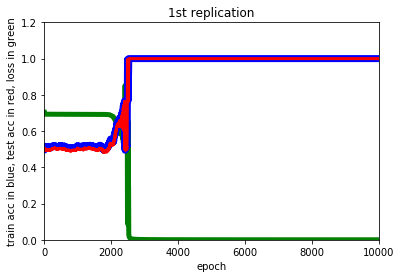

In [4]:
losses_1st_replication
plt.plot(losses_1st_replication, color='green', linewidth=5)
plt.plot(train_accuracies_1st_replication, color='blue', linewidth=7)
plt.plot(test_accuracies_1st_replication, color='red', linewidth=3)
plt.xlim(0, epochs)
plt.xlabel("epoch")
plt.ylim(0, 1.2)
plt.ylabel("train acc in blue, test acc in red, loss in green")
plt.title("1st replication")
plt.show()